In [7]:
import os
import cv2
import glob
import time
import random
import shutil #拷贝文件
import numpy as np
import mpl_toolkits
import imgaug as ia
import pandas as pd
from progressbar import * #进度条
from natsort import natsorted
import matplotlib.pyplot as plt
from skimage import io,transform
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from skimage.io import imread, imsave


os.environ['CUDA_VISIBLE_DEVICES']='3'

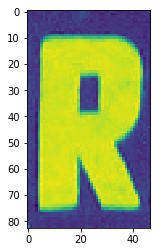

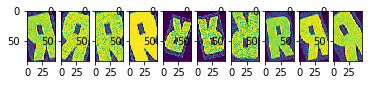

"\nimg2 = imread('data/train/2218.Bmp')\nimglist.append(img2)\nimages_aug = seq.augment_images(imglist)\nfor i in range(2):\n    plt.subplot(1, 2, i+1)\n    plt.imshow(images_aug[i])\n"

In [2]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap

def img_show(img):
    plt.imshow(img)

seq = iaa.SomeOf((2, None),[#将Augmenter中的部分变换应用在图片处理上，而不是应用所有的Augmenter
    iaa.GaussianBlur(sigma=iap.Uniform(0.0, 1.0)),#添加高斯滤波
    iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
    iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
    iaa.Flipud(0.3), #上下翻转
    iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
    iaa.Affine(scale=(0.5, 1), translate_percent=0.1, rotate=iap.Normal(0.0, 15)),#旋转
    iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
    #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
    iaa.AdditiveGaussianNoise(scale=(0,  0.05*255))
],random_order=True)#每个batch中的Augmenters顺序不一样

seq = iaa.Sequential([
    #iaa.GaussianBlur(sigma=iap.Uniform(0.0, 1.0)),#添加高斯扰动
    iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
    iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
    iaa.Flipud(0.5), #上下翻转
    #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
    iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-10, 10)),#旋转
    iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
    #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
    iaa.AdditiveGaussianNoise(scale=(0,  0.05*255)),
    iaa.Sharpen(alpha=0.5),
    #iaa.Scale({"height": (0.75, 1.25), "width": (0.75, 1.25)})
],random_order=True)#每个batch中的Augmenters顺序不一样


imglist = []
#img = imread('data/train/3006.Bmp', as_grey=True)

img = cv2.imread('data/train/2212.Bmp', 0)
#plt.subplot(2, 10, 1)
plt.imshow(img)
plt.show()
imglist.append(img)
for i in range(10):
    images_aug = seq.augment_images(imglist)
    plt.subplot(1, 10, i+1)
    plt.imshow(images_aug[0])
plt.show()


'''
img2 = imread('data/train/2218.Bmp')
imglist.append(img2)
images_aug = seq.augment_images(imglist)
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(images_aug[i])
'''

In [3]:
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)
print(images.shape)

(32, 64, 64, 3)


In [8]:
def label2int(ch):
    ascii_val = ord(ch)
    if(ascii_val <= 57): #0-9
        ascii_val -= 48
    elif(ascii_val <= 90): #A-Z
        ascii_val -= 55
    else: #a-z
        ascii_val -= 61
    return ascii_val
def int2label(i):
    if(i <= 9): #0-9
        i += 48
    elif(i<=35): #A-Z
        i += 55
    else: #a-z
        i += 61
    return chr(i)

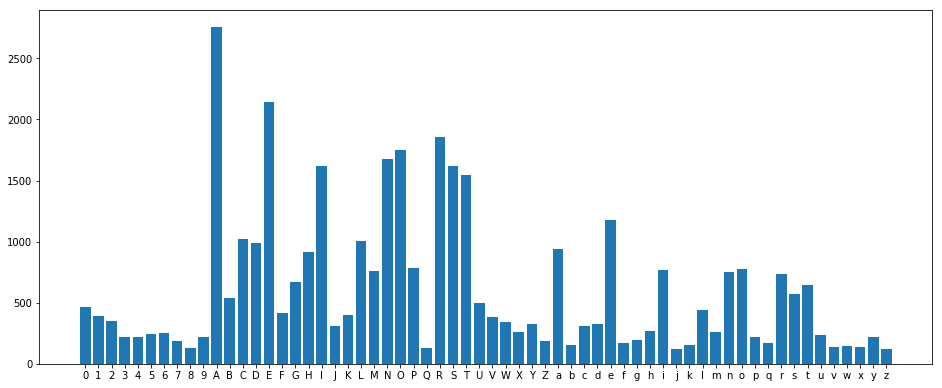

In [9]:
'''
原始数据分析
'''
### 数目统计
floders = natsorted(glob.glob('data/new_train/*'))
classes = []
file_num = []
for i, floder in enumerate(floders):
    floder_name = int(floder.split("/")[-1])
    classes.append(int2label(floder_name))
    file_num.append(len(glob.glob(floder + '/*')))
#print(classes)
plt.figure(figsize=(16, 6.5))
plt.bar(range(len(file_num)), file_num, tick_label=classes)
plt.show()
        

In [ ]:
### 数据可视化 ###
plt.figure(figsize=(10, 70))
num_classes = len(classes)
sample_pre_class = 10
for i, floder in enumerate(floders):
    files = glob.glob(floder + '/*')
    samples = random.sample(files, sample_pre_class)
    for idx, file in enumerate(samples):
        img = imread(file)
        dst = transform.resize(img, (244, 244))
        plt_idx = i * (sample_pre_class+1) + idx + 1
        #print(i, idx, plt_idx)
        plt.subplot(num_classes, sample_pre_class+1, plt_idx)

        plt.imshow(dst)
        plt.axis('off')
        if idx == sample_pre_class-1:
            plt.subplot(num_classes, sample_pre_class+1, plt_idx+1)
            floder_name = int(floder.split("/")[-1])
            plt.text(0.5, 0.5, int2label(floder_name),size=50,  verticalalignment='center')
            plt.axis('off')
plt.show()  

/home/lhw/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/lhw/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [53]:
'''
 训练数据按文件夹分离，并且扩充数据集
'''   
def split_data_as_class(data_path='data', new_data_floder = 'data/new_train'):
    seq = iaa.SomeOf((2, None),[#将Augmenter中的部分变换应用在图片处理上，而不是应用所有的Augmenter
        iaa.GaussianBlur(sigma=iap.Uniform(0.0, 1.0)),#添加高斯滤波
        iaa.Crop(percent=0.1), # # 从每侧裁剪图像0到16px（随机选择）
        iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
        iaa.Flipud(0.3), #上下翻转
        iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
        iaa.Affine(scale=(0.5, 1), translate_percent=0.1, rotate=iap.Normal(0.0, 15)),#旋转
        iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
        #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
        iaa.AdditiveGaussianNoise(scale=(0,  0.05*255))
    ],random_order=True)#每个batch中的Augmenters顺序不一样
    
    
    files = glob.glob(data_path + '/train/*')
    labels = pd.read_csv(data_path + '/trainLabels.csv')
    total = len(files)
    pbar = ProgressBar().start()
    for i, file_path in enumerate(files):
        pbar.update(int((i / (total - 1)) * 100))#进度条
        time.sleep(0.01)
        
        idx =  file_path.split('/')[-1][:-4]
        label = label2int(labels[labels.ID == int(idx)].Class.tolist()[0])
        new_floder = new_data_floder + '/' + str(label)
        if not os.path.exists(new_floder):
            os.makedirs(new_floder)
        new_file_path = new_floder + '/' + file_path.split("/")[-1]
        shutil.copyfile(file_path, new_file_path)
        ### 扩充数据集  ###
        img = cv2.imread(file_path)
        imglist = []
        imglist.append(img)
        for i in range(5):#随机产生5个数据
            images_aug = seq.augment_images(imglist)
            #plt.imshow(images_aug[0])
            cv2.imwrite(new_floder + '/' + str(idx) + '_aug_' + str(i) + '.Bmp', images_aug[0])
    pbar.finish()
    #print('Finish!')

In [54]:
### 扩充数据 ###
split_data_as_class()

Finish!
